# Future Impact of Ocean Acidification on Coral Reefs in the Great Barrier Reef

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
sns.set()

In [2]:
def get_linear_regression(df, x_feat_list, y_feat):
    
    # get target variable
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values
    
    reg = LinearRegression()

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)

    # print model
    model_str = y_feat + f' = {reg.intercept_:.3}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.3} {feat}'
    print(f'Formula for predicting {y_feat}: \n' + model_str)

    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')
    
    return (reg.intercept_, reg.coef_)

In [3]:
def create_prev_mean(df, mean_feat):
    """alters given dataframe by adding new "mean" column that represents the mean of previous 5 years' values
    
    Args:
        df (pd.DataFrame): dataframe
        mean_feat (str): feature we want to compute mean for
    
    Returns:
        df_mean (pd.DataFrame): dataframe altered with new "mean" for mean_feat
    """

    df_mean = df.copy()
    df_mean.reset_index(inplace=True)
    #print(df_mean)
    year_list = df.index.unique()
    means = []
    
    for i, year in enumerate(year_list):
        
        # years less than 5 are weird because they don't prev 5 years' data, so take mean of available years
        if i < 5:
            sum = 0
            
            # if this is the very first entry, we just set the mean to current entry
            if i == 0:
                mean = df.iloc[i, :][mean_feat]
            else:
                for idx in range(0, i):
                    data = df.iloc[idx, :]
                    sum += data[mean_feat]

                mean = sum / i
                    
        else:
            sum = 0
            # the 5 previous years
            for idx in range(i - 5, i):
                
                data = df.iloc[idx, :]
                sum += data[mean_feat]
            
            mean = sum / 5
        
        means.append(mean)
        
    df_mean[mean_feat + ' mean'] = means
    
    return df_mean

In [64]:
def plot_regression(df, x_feat_list, y_feat, df_predicted=None, title='', xlabel='', ylabel=''):
    """
    Creates scatter plot with linear regression model, plots predicted points if passed in
    
    Args:
        x (np.array): true x data
        y (np.array): true y data
        x_f (np.array): predicted x data (default=None)
        y_f (np.array): predicted y data (default=None)
        title (str): title of the plot
    Returns:
        intercept, coef (float, float): intercept and coef of the linear regression
    """
    
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    # compute mean squared error
    mse = ((y_pred - y) ** 2).mean()
    r2 = r2_score(y_true=y, y_pred=y_pred)
    
    # plot it
    plt.scatter(df['Year'], y, color='g', label='observed')
    plt.plot(df['Year'], y_pred, color='b', label='model (regression)')
        
    if df_predicted is not None:
        x_f = df_predicted.loc[:, x_feat_list].values
        y_f = df_predicted.loc[:, y_feat].values
        plt.scatter(df_predicted['Year'], y_f, color='r', label='predicted')
        
    plt.legend()

    sns.set(font_scale=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gcf().set_size_inches(10, 5)
    plt.gca().title.set_text(title)

    # print model
    model_str = y_feat + f' = {reg.intercept_:.3}'
    for feat, coef in zip(x_feat_list, reg.coef_):
        model_str += f' + {coef:.3} {feat}'
    print('Formula for prediciting pH level of Australian seawater: \n' + model_str)

    # compute r2
    r2 = r2_score(y_true=y, y_pred=y_pred)
    print(f'r2 = {r2:.3}')
        
    return (reg.intercept_, reg.coef_)

## Predicting CO2

Steps for predicting CO2:
1. Get the CO2 dataframe (do not exclude values past 2004, since we need these to predict future values)
2. Call plot_regression() to visualize this data and get linear regression model
3. Predict CO2 emissions up to 2050 using this linear regression model and add data to df_co2_predicted
4. Call plot_regression again to visualize old data and predicted data
5. Combine df_co2 with df_co2_predicted into df_co2_future. This can now be used to predict pH.

In [71]:
def get_australia_co2(trim_year=False):
    """Gets and cleans historic carbon emmissions data of Autralia into a DataFrame
    
    Args:
        trim_year (bool): do we want to exclude data not within 1959-2004? (default=False)
    
    Returns:
        df_co2 (DataFrame) : DataFrame containing the cleaned carbon emissions data
    """
    df_co2 = pd.read_csv('National_Carbon_Emissions_2020v1.0.csv')
    
    # Set columns to row 10
    df_co2.columns = df_co2.iloc[10]
    
    # remove all rows before row 10
    for index in df_co2.index:
        if index < 10:
            df_co2.drop(index, inplace=True)
            
    # Name the year column and delete nan values
    df_co2.rename(columns={df_co2.columns[0]:'Year'}, inplace=True)
    df_co2 = df_co2[df_co2['Year'].notna()]
    
    # Convert years to ints
    df_co2['Year'] = pd.to_numeric(df_co2['Year'])
    
    if trim_year:
        # we don't want data past 2004
        bool_series = df_co2['Year'] <= 2004
        df_co2 = df_co2.loc[bool_series, :]
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_co2.set_index(['Year'], inplace=True)
    
    
    # only use Australia's co2 emissions
    df_co2 = df_co2.loc[:, df_co2.columns == 'Australia']
    df_co2.rename(columns={df_co2.columns[0]:'CO2 emissions (MtC)'}, inplace=True)   
    df_co2['CO2 emissions (MtC)'] = pd.to_numeric(df_co2['CO2 emissions (MtC)'])

    
    return df_co2

df_co2 = get_australia_co2()
df_co2.head()

10,CO2 emissions (MtC)
Year,
1959,23
1960,24
1961,25
1962,26
1963,28


In [72]:
df_co2_mean = create_prev_mean(df_co2, 'CO2 emissions (MtC)')
df_co2_mean.head()

10,Year,CO2 emissions (MtC),CO2 emissions (MtC) mean
0,1959,23,23.0
1,1960,24,23.0
2,1961,25,23.5
3,1962,26,24.0
4,1963,28,24.5


In [73]:
x_feat_list = ['Year', 'CO2 emissions (MtC) mean']
y_feat = 'CO2 emissions (MtC)'

intercept, coefs = get_linear_regression(df_co2_mean, x_feat_list, y_feat)
#intercept, coefs = plot_regression(df_co2_mean, x_feat_list, y_feat, title='Australia CO2 Emissions Over the Years', xlabel='Year', ylabel=y_feat)

df_co2_mean.set_index('Year', inplace=True)

Formula for predicting CO2 emissions (MtC): 
CO2 emissions (MtC) = -1.72e+02 + 0.0909 Year + 0.933 CO2 emissions (MtC) mean
r2 = 0.993


In [74]:
# predict until 2050

df_co2_predicted = pd.DataFrame(columns = ['Year', y_feat, 'CO2 emissions (MtC) mean'])
df_co2_predicted.set_index('Year', inplace=True)

for i in range(0, 31):
    # calculate future co2 mean, will always have 5 previous years so no outlier/weird calculations
    year = 2020 + i 
    co2_sum = 0
    for idx in range(year - 5, year):
        if idx < 2020:
            co2_sum += df_co2_mean.loc[idx]['CO2 emissions (MtC)']
        else:
            co2_sum += df_co2_predicted.loc[idx]['CO2 emissions (MtC)']


    co2_mean = co2_sum / 5
    
    # plug values into formula to calculate predicted pH
    formula = intercept + (coefs[0] * year) + (coefs[1] * co2_mean)
    df_co2_predicted.loc[year] = [formula, co2_mean]

df_co2_predicted

,CO2 emissions (MtC),CO2 emissions (MtC) mean
Year,,
2020,116.482342,112.200000
2021,117.782727,113.496468
2022,118.952577,114.653014
2023,120.154118,115.843529
2024,121.393263,117.074353
2025,123.236766,118.953006
2026,124.587916,120.303890
2027,125.948537,121.664928
2028,127.344752,123.064120


Formula for prediciting pH level of Australian seawater: 
CO2 emissions (MtC) = -1.72e+02 + 0.0909 Year + 0.933 CO2 emissions (MtC) mean
r2 = 0.993


(-171.82932202038697, array([0.09091112, 0.93289848]))

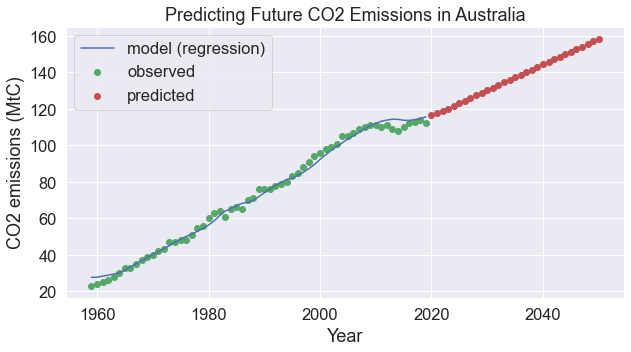

In [75]:
df_co2_predicted.reset_index(inplace=True)
df_co2_mean.reset_index(inplace=True)

plot_regression(df_co2_mean, x_feat_list, y_feat, df_co2_predicted, title='Predicting Future CO2 Emissions in Australia', xlabel='Year', ylabel=y_feat)

In [10]:
# add predicted values to df_co2
df_co2_future = pd.concat([df_co2_mean, df_co2_predicted])
df_co2_future.set_index('Year', inplace=True)

df_co2_future

10,CO2 emissions (MtC),CO2 emissions (MtC) mean
Year,,
1959,23.000000,23.000000
1960,24.000000,23.000000
1961,25.000000,23.500000
1962,26.000000,24.000000
1963,28.000000,24.500000
...,...,...
2046,152.770640,148.564738
2047,154.170153,149.967465
2048,155.568657,151.369110


## Predicting pH

Steps for predicting pH:
1. Create ```df_ph_co2``` with pH data (1959 - 2004) and previously constructed ```df_co2``` via ```get_ph_and_co2()```.
2. Rename dataframe as ```df_ph_co2_mean``` and add additional column to represent the average of the previous 5 years' pH levels via ```create_prev_mean()```.
3. Calculate multiple regression model and visualize.
4. Predict pH up to 2050 using this multiple regression model and add data to ```df_ph_predicted```.
5. Plot and visualize predicted multiple regression against observed samples.
6. Extract year and pH information from ```df_ph_predicted``` into ```df_ph_future``` which can now be used to predict coral calcification.

In [89]:
def get_ph_and_co2(df_co2):
    """ Gets pH information and creates combined dataframe with historical co2
    
    Args:
        df_co2 (pd.DataFrame) : dataframe of past future co2 emissions until 2004
    
    Returns:
        df_ph_co2 (pd.DataFrame): dataframe of past 
    """
    df_ph_co2 = pd.read_csv('arlington2009.csv')
    df_ph_co2.dropna(inplace=True)

    # remove unimportant columns
    del df_ph_co2['SampleID']
    del df_ph_co2['        d13C (per mil VPDB) *c']
    del df_ph_co2['        d18O (per mil VPDB) *c']
    del df_ph_co2['        d11B (per mil) *d']
    del df_ph_co2['2sigma']
    del df_ph_co2['   2sigma mean *e']
    del df_ph_co2['      Mg/Ca (x10-3) *b']
    del df_ph_co2['       Sr/Ca (x10-3) *b']
    del df_ph_co2['      Ba/Ca (x10-6)  *b']
    df_ph_co2.columns = ['Year', 'pH']
    
    
    bool_series = df_ph_co2['Year'] >= 1959
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    bool_series = df_ph_co2['Year'] <= 2004
    df_ph_co2 = df_ph_co2.loc[bool_series, :]
    
    # append co2 dataframe to get combined info (both pH and co2)
    df_co2.reset_index(inplace=True)
    df_ph_co2 = pd.merge(df_ph_co2, df_co2, on='Year', how='outer')
    df_ph_co2 = df_ph_co2.astype({"Year": int})
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_ph_co2.set_index(['Year'], inplace=True)
    

    return df_ph_co2

    
df_ph_co2 = get_ph_and_co2(get_australia_co2(True))
df_ph_co2.head()

,pH,CO2 emissions (MtC)
Year,,
1959,7.94,23
1960,8.01,24
1961,7.94,25
1962,7.90,26
1963,7.95,28


In [161]:
df_ph_co2_mean = create_prev_mean(df_ph_co2, 'pH')
df_ph_co2_mean.head()

,Year,pH,CO2 emissions (MtC),pH mean
0,1959,7.94,23,7.940000
1,1960,8.01,24,7.940000
2,1961,7.94,25,7.975000
3,1962,7.90,26,7.963333
4,1963,7.95,28,7.947500


In [162]:
x_feat_list = ['Year', 'pH mean']
y_feat = 'pH'

intercept, coefs = get_linear_regression(df_ph_co2_mean, x_feat_list, y_feat)

Formula for predicting pH: 
pH = 15.8 + -0.00381 Year + -0.0412 pH mean
r2 = 0.181


In [163]:
df_ph_co2_mean = df_ph_co2_mean.set_index("Year")

In [164]:
# predict until 2050

df_ph_predicted = pd.DataFrame(columns = ['Year', 'CO2 emissions (MtC)', y_feat])
df_ph_predicted.set_index('Year', inplace=True)

for i in range(0, 2051 - 2005):
    # calculate future co2 mean, will always have 5 previous years so no outlier/weird calculations
    year = 2005 + i 
    ph_sum = 0
    for idx in range(year - 5, year):
        if idx < 2005:
            ph_sum += df_ph_co2_mean.loc[idx][y_feat]
            #print(df_ph_co2_mean.loc[idx][y_feat])
        else:
            ph_sum += df_ph_predicted.loc[idx][y_feat]


    co2 = df_co2_future.loc[year]['CO2 emissions (MtC)']

    ph_mean = ph_sum / 5
    
    # plug values into formula to calculate predicted pH
    formula = intercept + (coefs[0] * year + coefs[1] * ph_mean)
    df_ph_predicted.loc[year] = [co2, formula]

df_ph_predicted.head()

,CO2 emissions (MtC),pH
Year,,
2005,105.0,7.865074
2006,107.0,7.860809
2007,109.0,7.856166
2008,110.0,7.853871
2009,111.0,7.851511


Formula for prediciting pH level of Australian seawater: 
pH = -61.6 + 0.0358 Year + -0.0221 CO2 emissions (MtC)
r2 = 0.291


(-61.625744910244606, array([ 0.03579274, -0.02212777]))

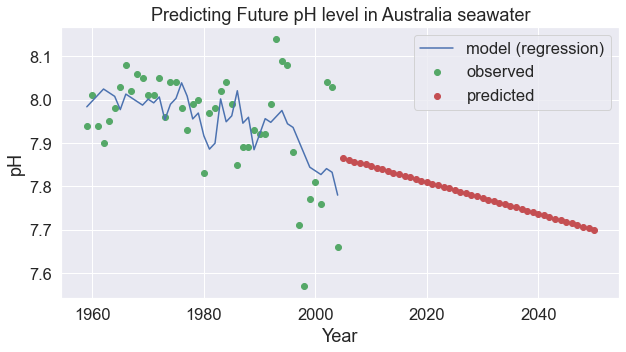

In [165]:
df_ph_predicted.reset_index(inplace=True)
df_ph_co2_mean.reset_index(inplace=True)

plot_regression(df_ph_co2_mean, ['Year', 'CO2 emissions (MtC)'], y_feat, df_ph_predicted, title='Predicting Future pH level in Australia seawater', xlabel='Year', ylabel=y_feat)

In [129]:
# add predicted values to df_co2
df_ph_future = pd.concat([df_ph_co2_mean, df_ph_predicted])
df_ph_future.set_index('Year', inplace=True)
del df_ph_future['pH mean']
df_ph_future

,pH,CO2 emissions (MtC)
Year,,
1959,7.940000,23.000000
1960,8.010000,24.000000
1961,7.940000,25.000000
1962,7.900000,26.000000
1963,7.950000,28.000000
...,...,...
2046,7.714364,152.770640
2047,7.710703,154.170153
2048,7.707043,155.568657


## Predicting Coral Calcification

Steps for predicting coral calcification:
1. Create ```df_coral``` with coral calcification data (1959 - 2004) and previously constructed ```df_ph_future``` via ```get_coral_ph_co2()```.
2. Rename dataframe as ```df_coral_ph_co2_mean``` and add additional column to represent the average of the previous 5 years' coral calcification levels via ```create_prev_mean()```.
3. Calculate multiple regression model and visualize.
4. Predict coral calcification up to 2050 using this multiple regression model and add data to ```df_coral_predicted```.
5. Plot and visualize predicted multiple regression against observed samples.
6. Extract year and coral calcification information from ```df_coral_predicted``` into ```df_coral_future``` which is the final output of predicting coral calcification until 2050.

In [130]:
def get_coral_ph_co2():
    """Obtains, cleans, and organizes the coral calficiation data into a DataFrame
    
    Returns:
        df_coral (DataFrame) : DataFrame containing the cleaned coral calcification data (including all columns)
    """
    df_coral = pd.read_csv("GBR-coral-calcification.csv")
    df_coral.dropna(axis=0, inplace=True)
    
    del df_coral['Reef']
    del df_coral['ext']
    del df_coral['den']
    df_coral.columns = ['Year', 'id', 'calc rate(g/cm^2/yr)']
    
    
    bool_series = df_coral['Year'] >= 1959 
    df_coral = df_coral.loc[bool_series, :]
    
    bool_series = df_coral['Year'] <= 2004
    df_coral = df_coral.loc[bool_series, :]
    
    df_coral = df_coral.groupby('Year').mean()
    
    # append ph dataframe to get combined info (both coral calc + pH + co2)
    df_ph = df_ph_future.reset_index()
    # get only values earlier than 2005
    series_ph_future = df_ph['Year'] <= 2004
    df_ph = df_ph.loc[series_ph_future, :]
    
    df_coral = pd.merge(df_coral, df_ph, on='Year', how='outer')
    df_coral = df_coral.astype({"Year": int})
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_coral.set_index(['Year'], inplace=True)
    
    return df_coral

df_coral = get_coral_ph_co2()
df_coral.head()

,calc rate(g/cm^2/yr),pH,CO2 emissions (MtC)
Year,,,
1959,1.620043,7.94,23.0
1960,1.633343,8.01,24.0
1961,1.625227,7.94,25.0
1962,1.626569,7.90,26.0
1963,1.728867,7.95,28.0


In [153]:
df_coral_ph_co2_mean = create_prev_mean(df_coral, 'calc rate(g/cm^2/yr)')
df_coral_ph_co2_mean

,Year,calc rate(g/cm^2/yr),pH,CO2 emissions (MtC),calc rate(g/cm^2/yr) mean
0,1959,1.620043,7.94,23.0,1.620043
1,1960,1.633343,8.01,24.0,1.620043
2,1961,1.625227,7.94,25.0,1.626693
3,1962,1.626569,7.90,26.0,1.626204
4,1963,1.728867,7.95,28.0,1.626295
5,1964,1.724254,7.98,30.0,1.646810
6,1965,1.682149,8.03,33.0,1.667652
7,1966,1.671115,8.08,33.0,1.677413
8,1967,1.631265,8.02,35.0,1.686591
9,1968,1.623504,8.06,37.0,1.687530


In [154]:
x_feat_list = ['pH', 'calc rate(g/cm^2/yr) mean']
y_feat = 'calc rate(g/cm^2/yr)'

intercept, coefs = get_linear_regression(df_coral_ph_co2_mean, x_feat_list, y_feat)

Formula for predicting calc rate(g/cm^2/yr): 
calc rate(g/cm^2/yr) = -1.63 + 0.237 pH + 0.849 calc rate(g/cm^2/yr) mean
r2 = 0.358


In [155]:
df_coral_ph_co2_mean.set_index('Year', inplace=True)

In [157]:
# predict until 2050

df_coral_predicted = pd.DataFrame(columns = ['Year','CO2 emissions (MtC)', 'pH', y_feat])
df_coral_predicted.set_index('Year', inplace=True)

for i in range(0, 2051 - 2005):
    # calculate future co2 mean, will always have 5 previous years so no outlier/weird calculations
    year = 2005 + i 
    coral_sum = 0
    for idx in range(year - 5, year):
        if idx < 2005:
            coral_sum += df_coral_ph_co2_mean.loc[idx][y_feat]
            #print(df_ph_co2_mean.loc[idx][y_feat])
        else:
            coral_sum += df_coral_predicted.loc[idx][y_feat]


    co2 = df_ph_future.loc[year]['CO2 emissions (MtC)']
    pH = df_ph_future.loc[year]['pH']

    coral_mean = coral_sum / 5
    
    # plug values into formula to calculate predicted pH
    formula = intercept + (coefs[0] * pH) + (coefs[1] * coral_mean)
    df_coral_predicted.loc[year] = [co2, pH, formula]

df_coral_predicted

,CO2 emissions (MtC),pH,calc rate(g/cm^2/yr)
Year,,,
2005,105.000000,7.865074,1.663631
2006,107.000000,7.860809,1.668799
2007,109.000000,7.856166,1.658390
2008,110.000000,7.853871,1.638323
2009,111.000000,7.851511,1.626403
2010,111.000000,7.846121,1.636719
2011,110.000000,7.842466,1.631282
2012,111.000000,7.838806,1.624043
2013,109.000000,7.835138,1.617340


Formula for prediciting pH level of Australian seawater: 
calc rate(g/cm^2/yr) = -6.4 + 0.00308 Year + 0.252 pH
r2 = 0.295


(-6.402252675561813, array([0.00308127, 0.25161291]))

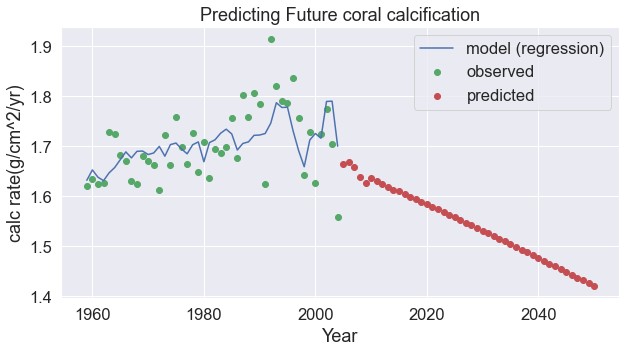

In [151]:
df_coral_predicted.reset_index(inplace=True)
df_coral_ph_co2_mean.reset_index(inplace=True)

plot_regression(df_coral_ph_co2_mean, ['Year', 'pH'], y_feat, df_coral_predicted, title='Predicting Future coral calcification', xlabel='Year', ylabel=y_feat)